<a href="https://colab.research.google.com/github/ryanamundson1/gcolab/blob/master/bivariate_cloropleth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import geopandas
import geoplot
import os
import pandas
import requests
import fiona
import io
import tempfile
import zipfile

First import the shape files for the United States state data

In [3]:
data = requests.get("https://raw.githubusercontent.com/ryanamundson1/gcolab/master/shapes/gz_2010_us_040_00_5m.zip")
temp_dir = tempfile.TemporaryDirectory(suffix=".zip")

z = zipfile.ZipFile(io.BytesIO(data.content))

z.extractall(path=temp_dir.name) # extract to folder
filenames = [y for y in sorted(z.namelist()) for ending in ['dbf', 'prj', 'shp', 'shx'] if y.endswith(ending)] 

country = geopandas.read_file(temp_dir.name + "/gz_2010_us_040_00_5m/gz_2010_us_040_00_5m.shp")
country.head()

,GEO_ID,STATE,NAME,LSAD,CENSUSAREA,geometry
0,0400000US01,01,Alabama,None,50645.326,"MULTIPOLYGON (((-88.12466 30.28364, -88.08681 ..."
1,0400000US02,02,Alaska,None,570640.950,"MULTIPOLYGON (((-166.10574 53.98861, -166.0752..."
2,0400000US04,04,Arizona,None,113594.084,"POLYGON ((-112.53859 37.00067, -112.53454 37.0..."
3,0400000US05,05,Arkansas,None,52035.477,"POLYGON ((-94.04296 33.01922, -94.04304 33.079..."
4,0400000US06,06,California,None,155779.220,"MULTIPOLYGON (((-122.42144 37.86997, -122.4213..."


Now we can load data into dataframes to join against the state data. I'm using mortality rates from CDC's wonder site: https://wonder.cdc.gov/cmf-ICD10.html

In [22]:
mortality = pandas.read_csv("https://raw.githubusercontent.com/ryanamundson1/gcolab/master/data/gc/firearm_mort_2017-2019.txt", sep='\t')
#firearmdf = mortality[mortality['Cause of death'].str.contains("discharge")==True]
firearmdf['Rate'] = firearmdf['Crude Rate'].str.extract('(\d+[.]\d+)').astype(float)

#Get the mean mortality for each state 
staterate = firearmdf.groupby("State").agg({'Deaths':'sum', 'Rate':'mean','Population':'mean'}).reset_index()
staterate["crude_rate_100k"] =  (staterate["Deaths"] / staterate["Population"]) * 100000
staterate.head()

,State,Deaths,Rate,Population,crude_rate_100k
0,Alabama,2795.0,1.090000,28496755.0,9.808134
1,Alaska,622.0,2.668000,4664845.0,13.333776
2,Arizona,3349.0,0.962222,38661164.0,8.662440
3,Arkansas,1446.0,0.824000,17557789.0,8.235661
4,California,15212.0,0.590000,234398139.0,6.489813


Now get the gun law scores using this site. I'm coverting the grades into numerical data and inverting them for the cloropleth. The grades have been extracted from the Gun Law Scorecard: https://lawcenter.giffords.org/scorecard/

In [23]:
laws = pandas.read_csv("https://raw.githubusercontent.com/ryanamundson1/gcolab/master/data/gc/gun_law_scores.txt")
grades = [('A+', 4.0), ('A', 4.0), ('A-', 3.7), ('B+',3.3), ('B',3.0), ('B-',2.7), ('C+',2.3), ('C',2.0),
          ('C-',1.7),('D+',1.3),('D',1.0),('D-',0.7),('F',0.0)]

grades = dict(grades)
laws["number_grade_inv"] = laws["grade"].apply(lambda x: 4 - grades.get(x))
laws["number_grade"] = laws["grade"].apply(lambda x: grades.get(x))
laws.head()

,rank,state,grade,deaths,value,number_grade_inv,number_grade
0,1,California,A,44,7.8,0.0,4.0
1,2,New Jersey,A,45,5.3,0.0,4.0
2,3,Connecticut,A-,46,5.1,0.3,3.7
3,4,Maryland,A-,29,12.3,0.3,3.7
4,5,Massachusetts,A-,49,3.7,0.3,3.7


In [24]:
# merge the data into a DF
merged = country.merge(staterate, left_on='NAME', right_on='State', how='outer')
merged = merged.merge(laws, left_on='NAME', right_on='state', how='outer')
mergedNoAH = merged[merged['NAME'].isin(['Alaska','Hawaii']) == False].fillna(0)

mergedNoAH.head()

,GEO_ID,STATE,NAME,LSAD,CENSUSAREA,geometry,State,Deaths,Rate,Population,crude_rate_100k,rank,state,grade,deaths,value,number_grade_inv,number_grade
0,0400000US01,01,Alabama,0,50645.326,"MULTIPOLYGON (((-88.12466 30.28364, -88.08681 ...",Alabama,2795.0,1.090000,28496755.0,9.808134,37.0,Alabama,F,2.0,22.9,4.0,0.0
2,0400000US04,04,Arizona,0,113594.084,"POLYGON ((-112.53859 37.00067, -112.53454 37.0...",Arizona,3349.0,0.962222,38661164.0,8.662440,46.0,Arizona,F,18.0,15.7,4.0,0.0
3,0400000US05,05,Arkansas,0,52035.477,"POLYGON ((-94.04296 33.01922, -94.04304 33.079...",Arkansas,1446.0,0.824000,17557789.0,8.235661,41.0,Arkansas,F,7.0,20.2,4.0,0.0
4,0400000US06,06,California,0,155779.220,"MULTIPOLYGON (((-122.42144 37.86997, -122.4213...",California,15212.0,0.590000,234398139.0,6.489813,1.0,California,A,44.0,7.8,0.0,4.0
5,0400000US08,08,Colorado,0,103641.888,"POLYGON ((-106.19055 40.99761, -106.06118 40.9...",Colorado,1793.0,0.663333,30063040.0,5.964134,15.0,Colorado,C,24.0,13.4,2.0,2.0


Now let's make some charts, the states with low grades in gun control laws in blue, and the mortality rate for kids are in red

/usr/local/lib/python3.9/site-packages/geoplot/geoplot.py:626: UserWarning: Cannot set "figsize" when passing an "ax" to the plot. To remove this warning omit the "figsize" parameter.
  warnings.warn(


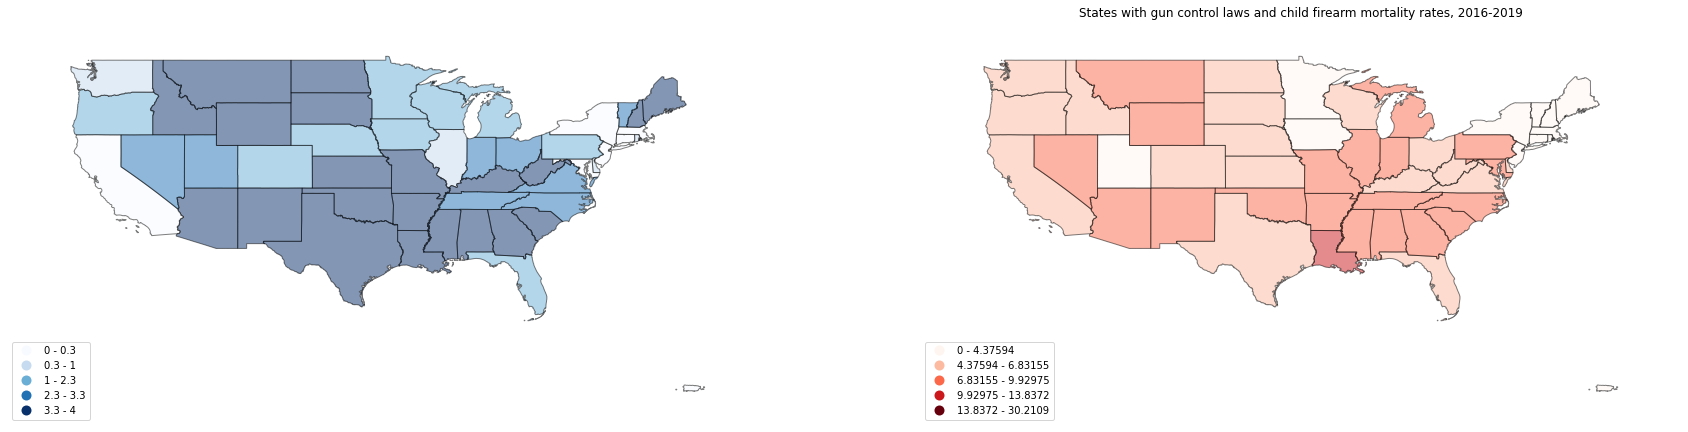

In [25]:
import matplotlib.pyplot as plt

#f, ax = plt.subplots(1)
fig = plt.figure(figsize=(30,20))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

plot1 = geoplot.choropleth(
    mergedNoAH, alpha=0.5, hue=mergedNoAH['number_grade_inv'],
    cmap='Blues',  scheme='FisherJenks', figsize=(30, 20), legend=True, ax=ax1
)
plot2 = geoplot.choropleth(
    mergedNoAH, alpha=0.5, hue=mergedNoAH['crude_rate_100k'],
    cmap='Reds', figsize=(30, 20), legend=True, scheme='FisherJenks', ax=ax2
)
#plt.show()

plt.title("States with gun control laws and child firearm mortality rates, 2016-2019")

plt.savefig("gc-laws-and-gun-mortality.png", bbox_inches='tight', pad_inches=0.1)

Now let's get the Pearson correlation to see how correlated the two variables are

In [26]:
merged['number_grade_inv'].corr(merged['crude_rate_100k'])

0.4542246425506724